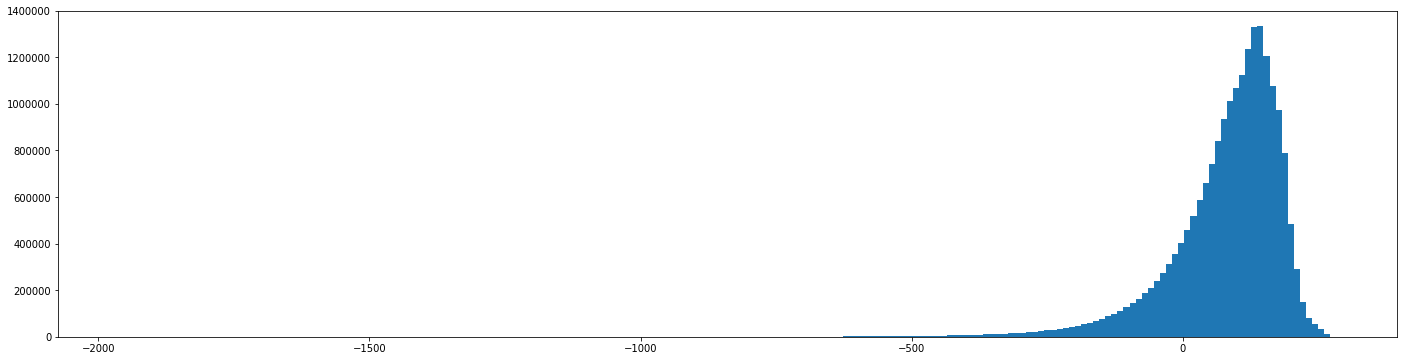

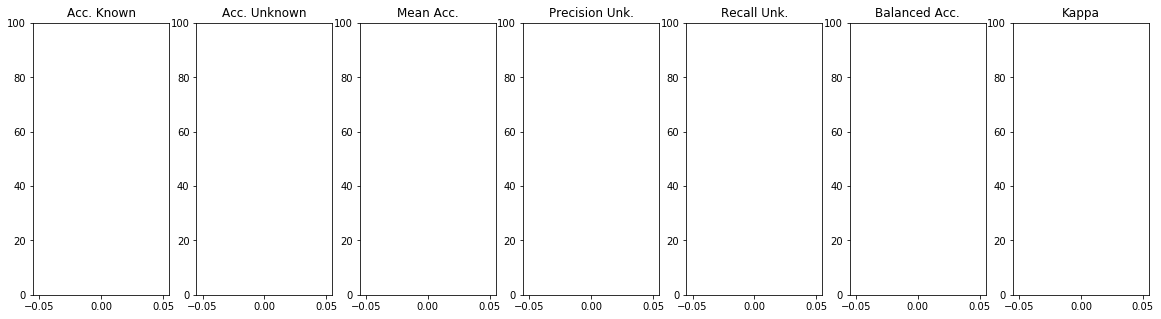

In [1]:
import os
import numpy as np
import matplotlib as mplt

from skimage import io

from sklearn import metrics

from matplotlib import pyplot as plt
from matplotlib import lines

%matplotlib inline

def plot_confusion_matrix(cm, classes, ax, title, cmap):
    
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0.0, vmax=100.0)
    if title is not None:
        ax.set_title(title)
    
    # We want to show all ticks...
    ax.set(xticklabels=classes, yticklabels=classes,
           ylabel='Real Class',
           xlabel='Predicted Class')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

'''
Classes:
    0 = Street
    1 = Building
    2 = Grass
    3 = Tree
    4 = Car
    5 = Surfaces
    6 = Boundaries
'''

##########################################################################################
##########################################################################################
##########################################################################################

epoch = 200

conv_name = 'unet'
# conv_name = 'fcnresnet50'
# conv_name = 'fcnresnext50'
# conv_name = 'fcnwideresnet50'
# conv_name = 'fcndensenet121'
# conv_name = 'fcnvgg19'
# conv_name = 'fcnvgg19pretrained'
# conv_name = 'fcninceptionv3'
# conv_name = 'fcnmobilenetv2'
# conv_name = 'segnet'

dataset_name = 'Vaihingen'
# dataset_name = 'Potsdam'


n_known = 4
class_unk = 0
classes = ['', 'Building', 'Grass', 'Tree', 'Car', 'Unk. (Street)']

# n_known = 4
# class_unk = 1
# classes = ['', 'Street', 'Grass', 'Tree', 'Car', 'Unk. (Building)']

# n_known = 4
# class_unk = 2
# classes = ['', 'Street', 'Building', 'Tree', 'Car', 'Unk. (Grass)']

# n_known = 4
# class_unk = 3
# classes = ['', 'Street', 'Building', 'Grass', 'Car', 'Unk. (Tree)']

# n_known = 4
# class_unk = 4
# classes = ['', 'Street', 'Building', 'Grass', 'Tree', 'Unk. (Car)']

# n_known = 3
# class_unk = '0_1'
# classes = ['', 'Grass', 'Tree', 'Car', 'Unk. (Street/Building)']

# n_known = 3
# class_unk = '2_3'
# classes = ['', 'Street', 'Building', 'Car', 'Unk. (Grass/Tree)']

# n_known = 2
# class_unk = '0_1_4'
# classes = ['', 'Grass', 'Tree', 'Unk. (Street/Building/Car)']

# n_known = 2
# class_unk = '2_3_4'
# classes = ['', 'Street', 'Building', 'Unk. (Grass/Tree/Car)']

img_dir = './outputs/%s_%s_openpca_full_%s/epoch_%d/' % (conv_name, dataset_name, str(class_unk), epoch)

##########################################################################################
##########################################################################################

thresholds = []
if conv_name == 'unet':
    
    # U-net.
    if dataset_name == 'Vaihingen':
        thresholds = [100, 120, 140, 160, 180, 200, 220, 240, 260, 280]
    elif dataset_name == 'Potsdam':
        thresholds = [-40, 0, 40, 80, 120, 160, 200, 220, 240, 260, 280, 300]
    
elif conv_name == 'fcnresnet50':

    # FCN ResNet-50.
    thresholds = [-1200, -1100, -1000, -900, -800, -700, -600, -500, -450, -400, -350, -300]
    
elif conv_name == 'fcnresnext50':

    # FCN ResNext-50.
    thresholds = [-1200, -1100, -1000, -900, -800, -700, -600, -500, -450, -400, -350, -300]
    
elif conv_name == 'fcnwideresnet50':

    # FCN Wide ResNet-50.
    thresholds = [-1200, -1100, -1000, -900, -800, -700, -600, -500, -450, -400, -350, -300]
    
elif conv_name == 'fcndensenet121':

    # FCN DenseNet-121.
    thresholds = [-280, -240, -200, -160, -140, -120, -100, -80]
    
elif conv_name == 'fcndensenet121pretrained':

    # FCN DenseNet-121.
    thresholds = [-280, -240, -200, -160, -140, -120, -100, -80]
    
elif conv_name == 'fcnvgg19':

    # FCN VGG-19 BN.
    thresholds = [-280, -240, -200, -160, -140, -120, -100, -80]
    
elif conv_name == 'fcnvgg19pretrained':

    # FCN VGG-19 BN.
    thresholds = [-280, -240, -200, -160, -140, -120, -100, -80]
    
elif conv_name == 'fcninceptionv3':

    # FCN Inception v3.
    thresholds = [-280, -240, -200, -160, -140, -120, -100, -80]
    
elif conv_name == 'fcnmobilenetv2':

    # FCN MobileNet v2.
    thresholds = [-800, -760, -720, -700, -680, -660, -640, -620, -600]
    
elif conv_name == 'segnet':

    # SegNet.
    thresholds = [-100, -80, -60, -40, -20, 0, 20, 40, 60, 80, 100, 120, 140]

files = [f for f in os.listdir(img_dir) if os.path.isfile(os.path.join(img_dir, f)) and '_imag_' in f]

tru_list = []
pos_list = []
scr_list = []

for i, f in enumerate(files):

    img_path = os.path.join(img_dir, f)
    tru_path = os.path.join(img_dir, f.replace('_imag_', '_true_'))
    pri_path = os.path.join(img_dir, f.replace('_imag_', '_prev_'))
    scr_path = os.path.join(img_dir, f.replace('_imag_', '_scor_').replace('.png', '.npy'))

    try:
        img = io.imread(img_path)
        tru = io.imread(tru_path)
        pri = io.imread(pri_path)
        pos = np.copy(pri)
        scr = np.load(scr_path)
    except:
        print('Error in loading sample "' + f + '"')
        break

    tru_list.append(tru)
    pos_list.append(pos)
    scr_list.append(scr)

scr_np = np.asarray(scr_list).ravel()

plt.figure(figsize=(24, 6))
plt.hist(scr_np[scr_np > -2000], bins=200)
plt.show()

cm_list = []
acc_known_list = []
pre_unk_list = []
rec_unk_list = []
acc_unknown_list = []
acc_mean_list = []
acc_bal_list = []
kappa_list = []

for t in thresholds:
    
    tru_np = np.asarray(tru_list).ravel()
    pos_np = np.asarray(pos_list).ravel()

    pos_np[scr_np < t] = n_known
    
    tru_valid = tru_np[tru_np < 5]
    pos_valid = pos_np[tru_np < 5]
    
    cm = metrics.confusion_matrix(tru_valid, pos_valid)

    tru_known = 0.0
    sum_known = 0.0

    for c in range(n_known):
        tru_known += float(cm[c, c])
        sum_known += float(cm[c, :].sum())
    
    acc_known = float(tru_known) / float(sum_known)
    
    tru_unknown = float(cm[n_known, n_known])
    sum_unknown_real = float(cm[n_known, :].sum())
    sum_unknown_pred = float(cm[:, n_known].sum())

    pre_unknown = float(tru_unknown) / float(sum_unknown_pred)
    rec_unknown = float(tru_unknown) / float(sum_unknown_real)
    
    acc_unknown = (tru_known + tru_unknown) / (sum_known + sum_unknown_real)
    
    acc_mean = (acc_known + acc_unknown) / 2.0

    bal = metrics.balanced_accuracy_score(tru_valid, pos_valid)
    kap = metrics.cohen_kappa_score(tru_valid, pos_valid)

    print('Threshold %d - Acc. Known: %.2f%%, Acc. Unk.: %.2f%%, Pre. Unk.: %.2f%%, Rec. Unk.: %.2f%%, Balanced Acc.: %.2f%%, Kappa: %.2f%%' % (t, acc_known * 100.0, acc_unknown * 100.0, pre_unknown * 100.0, rec_unknown * 100.0, bal * 100.0, kap * 100.0))
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    
    cm_pred = cm.astype(np.float32)
    for c in range(n_known + 1):
        cm_pred[:(n_known + 1), c] /= cm_pred[:(n_known + 1), c].sum()
    plot_confusion_matrix(cm_pred[:(n_known + 1), :(n_known + 1)] * 100.0, classes, ax[0], 'CM (Pred.) OpenPCA t = %d' % (t), plt.cm.Blues)
    
    cm_real = cm.astype(np.float32)
    for c in range(n_known + 1):
        cm_real[c, :(n_known + 1)] /= cm_real[c, :(n_known + 1)].sum()
    plot_confusion_matrix(cm_real[:(n_known + 1), :(n_known + 1)] * 100.0, classes, ax[1], 'CM (Real) OpenPCA t = %d' % (t), plt.cm.Blues)
    
    plt.show()
    
    acc_known_list.append(acc_known)
    pre_unk_list.append(pre_unknown)
    rec_unk_list.append(rec_unknown)
    acc_unknown_list.append(acc_unknown)
    acc_mean_list.append(acc_mean)
    acc_bal_list.append(bal)
    kappa_list.append(kap)

thresholds = np.asarray(thresholds)
acc_known_list = np.asarray(acc_known_list) * 100
pre_unk_list = np.asarray(pre_unk_list) * 100
rec_unk_list = np.asarray(rec_unk_list) * 100
acc_unknown_list = np.asarray(acc_unknown_list) * 100
acc_mean_list = np.asarray(acc_mean_list) * 100
acc_bal_list = np.asarray(acc_bal_list) * 100
kappa_list = np.asarray(kappa_list) * 100


fig, ax = plt.subplots(1, 7, figsize=(20, 5))

ax[0].plot(thresholds, acc_known_list, '.-')
ax[0].set_title('Acc. Known')
ax[0].set_ylim([0, 100])

ax[1].plot(thresholds, acc_unknown_list, '.-')
ax[1].set_title('Acc. Unknown')
ax[1].set_ylim([0, 100])

ax[2].plot(thresholds, acc_mean_list, '.-')
ax[2].set_title('Mean Acc.')
ax[2].set_ylim([0, 100])

ax[3].plot(thresholds, pre_unk_list, '.-')
ax[3].set_title('Precision Unk.')
ax[3].set_ylim([0, 100])

ax[4].plot(thresholds, rec_unk_list, '.-')
ax[4].set_title('Recall Unk.')
ax[4].set_ylim([0, 100])

ax[5].plot(thresholds, acc_bal_list, '.-')
ax[5].set_title('Balanced Acc.')
ax[5].set_ylim([0, 100])

ax[6].plot(thresholds, kappa_list, '.-')
ax[6].set_title('Kappa')
ax[6].set_ylim([0, 100])

plt.show()

In [2]:
print('acc_known_list', acc_known_list)
print('acc_unknown_list', acc_unknown_list)
print('acc_mean_list', acc_mean_list)
print('pre_unk_list', pre_unk_list)
print('rec_unk_list', rec_unk_list)
print('acc_bal_list', acc_bal_list)
print('kappa_list', kappa_list)

for i in range(len(thresholds)):
    
    print('%.2f\t%.2f\t%.2f\t%.2f\t%.2f\t%.2f\t%.2f' % (acc_known_list[i],
                                                        acc_unknown_list[i],
                                                        acc_mean_list[i],
                                                        pre_unk_list[i],
                                                        rec_unk_list[i],
                                                        acc_bal_list[i],
                                                        kappa_list[i]))

acc_known_list []
acc_unknown_list []
acc_mean_list []
pre_unk_list []
rec_unk_list []
acc_bal_list []
kappa_list []
